### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

### Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [36]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Random state seed
rseed = 42

### Load and explore data

In [38]:
# Import the dataset
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [39]:
# Check the shape
data.shape

(167, 10)

In [40]:
# Check datatypes & counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [41]:
# Get descriptive statistics
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [42]:
# Identify any missing data
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [43]:
# Drop any non-numeric features (columns)
data = data.select_dtypes(include=[np.number])

data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Text(0.5, 1.0, 'Correlation Heatmap')

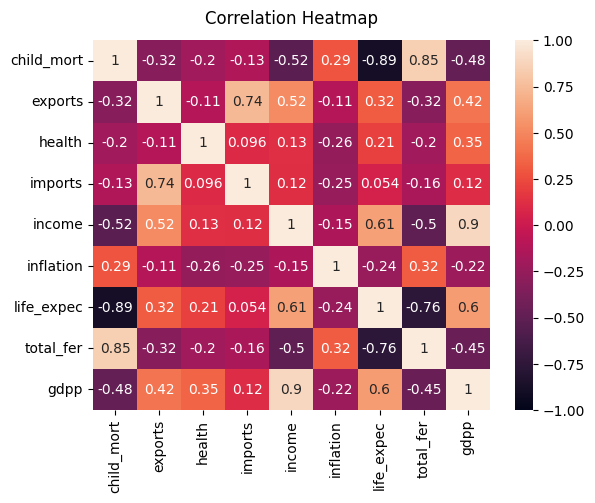

In [44]:
# Create a correlation map of features to explore relationships between features
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

The correlation matric reveals the strength and direction of linear relationships between the Gross Domestic Product per capita (GDPP) and various socio-economic indicators.

* Income (0.90): The strongest positive correlation with GDPP is seen with income. A correlation coefficient of 0.90 indicates a very strong direct relationship. This suggests that as income levels increase within a country, the GDPP also tends to be significantly higher. This relationship underscores the importance of personal and household incomes as a critical driver of economic output and prosperity. 

* Life Expectancy (0.60): Life expectancy shows a strong positive correlation with GDPP. This indicates that countries with higher GDPP tend to have longer average life expectancies. The linkage here can be attributed to better healthcare, improved living conditions, and greater access to medical services typically available in wealthier nations.

* Child Mortality (-0.48): There is a moderate negative correlation between child mortality and GDPP. This suggests that higher GDPP is associated with lower child mortality rates. This inverse relationship likely reflects the better healthcare systems, higher standards of living, and improved maternal and child health services in more affluent countries. 

* Total Fertility Rate (-0.45): The total fertility rate has a moderate negative correlation with GDPP. This indicates that countries with higher economic output per capita tend to have lower fertility rates. This could be due to a combination of factors, including higher educational levels, greater access to family planning, and economic conditions that favor smaller family sizes. 

* Exports (0.42): Exports show a moderate positive correlation with GDPP. This suggests that countries with higer GDPP tend to have higher levels of exports. A robust export sector can be a significant contributor to economic growth, reflecting the global demand for a country's goods and services.

* Health Expenditure (0.35): There is a modest positive correlation between health expenditure and GDPP. This indicates that higher GDPP is often accompanied by greater spending on health. Wealthier countries can allocate more resources to healthcare, leading to better health outcomes and reinforcing the overall economic productivity.

* Inflation (-0.22): Inflation shows a low negative correlation with GDPP. This weak inverse relationship implies that higher levels of inflation are slightly associated with lower GDPP. High inflation can erode purchasing power and economic stability, potentially hindering economic growth, but its impact appears to be relatively modest in this context. 

* Imports (0.12): Imports exhibit a low positive correlation with GDPP. This weak correlation suggests that while there is a slight tendency for countries with higher GDPP to import more, the relationship is not particularly strong. It indicates that the level of imports is not a major determinant of economic output per capita.


In summary, income and life expectancy are strongly correlated with GDPP, indicating that wealthier countries enjoy higher standards of living and health outcomes. Moderate correlations with child mortality, total fertility rate, and exports suggest significant, though less pronounced, links between these variables and economic prosperity. Meanwhile, health expenditure shows a modest positive association, and imports and inflation exhibit weaker correlations with GDPP, reflecting their more nuanced roles in economic performance. 

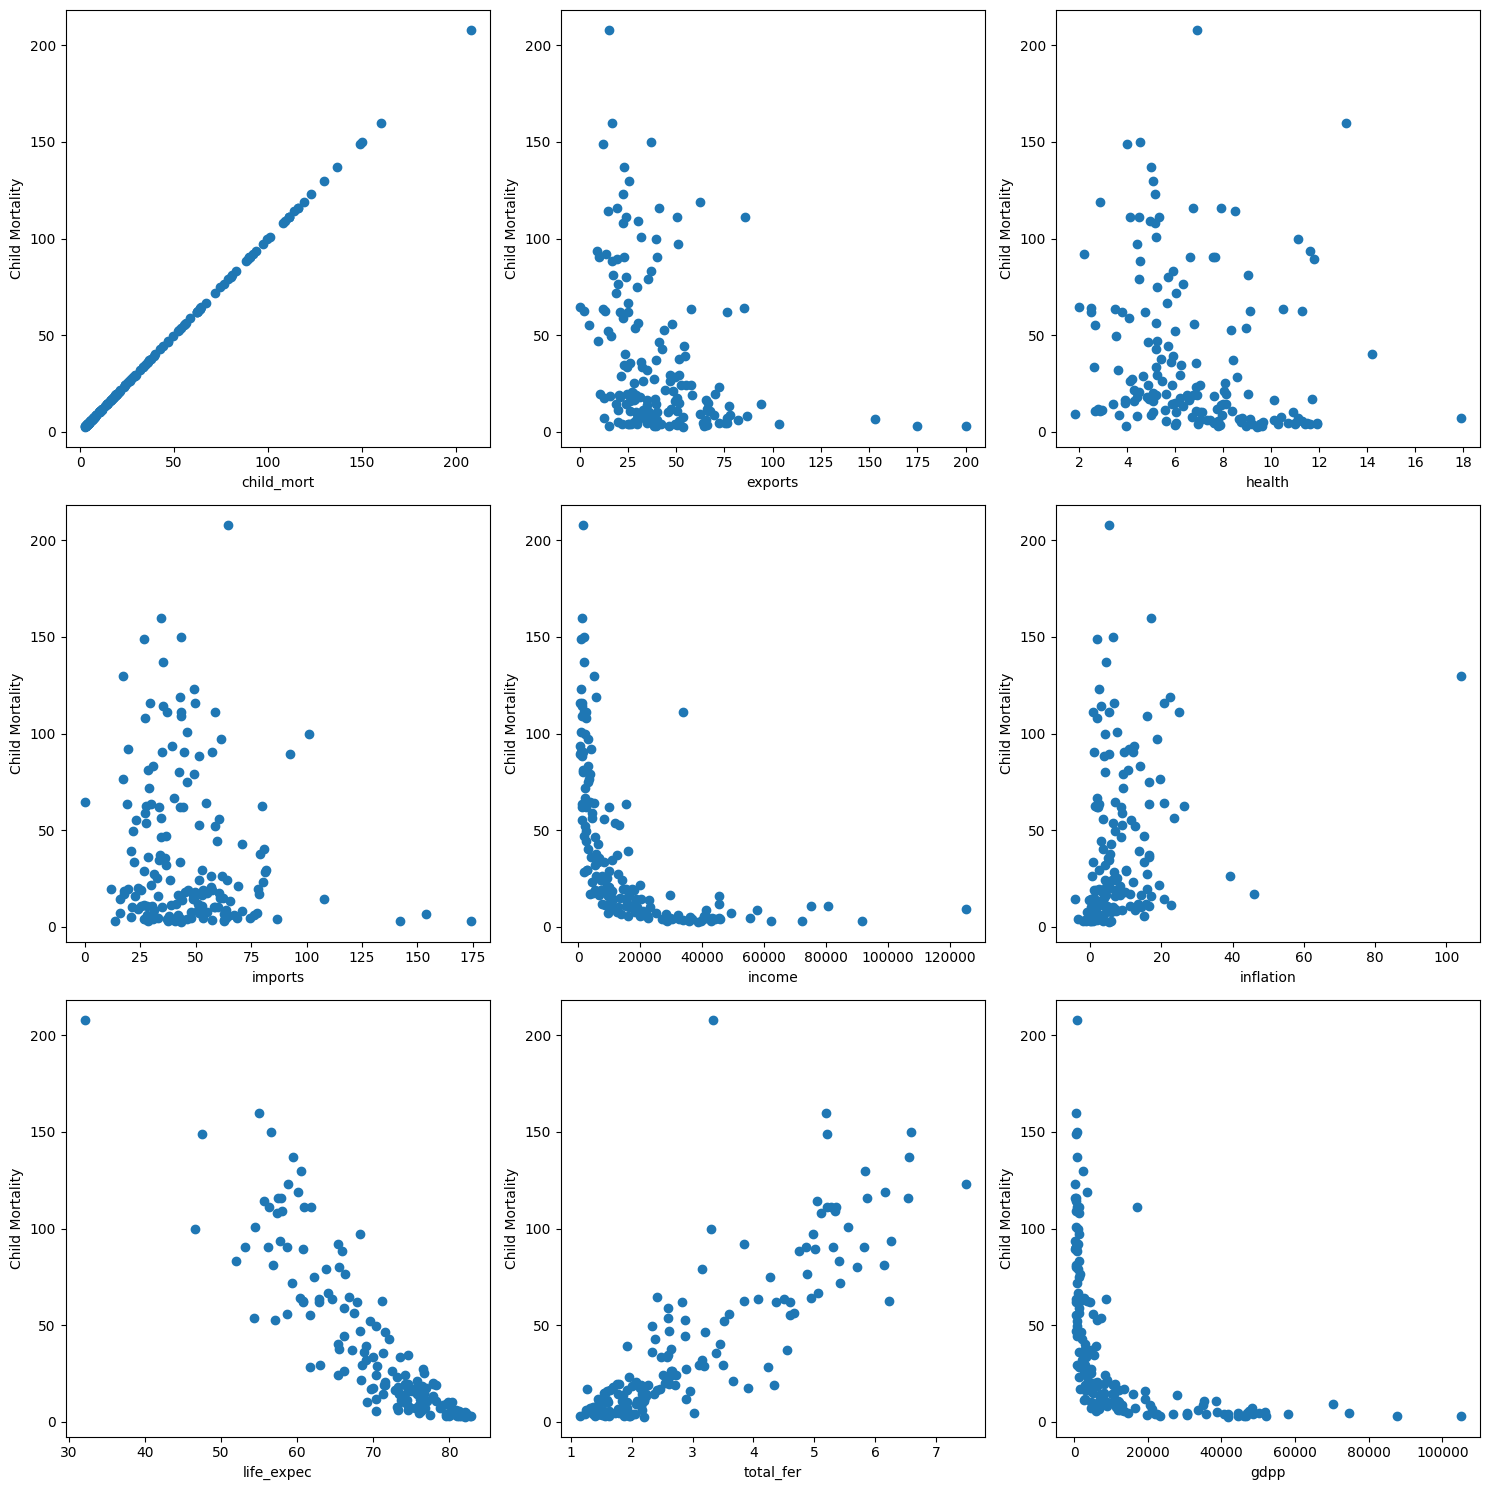

In [45]:
# Explore the continuous independent features against child_mort using scatter plots.
variables = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
child_mort = data['child_mort']

fig, axes = plt.subplots(3,3, figsize=(15, 15))

for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(data[var], child_mort)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Child Mortality')

plt.tight_layout()
plt.show()

In analysing the scatter plots, several combinations of variables stand out as good candidates for clustering. Here's a detailed explanation of why these particular plots are suitable: 

* ### Child Mortality vs. Exports

  Rationale: This plot is likely to reveal distinct clusters because economic activities related to exports significantly impact child mortality rates. Countries with higher exports levels often have better healthcare systems and infrastructure, leading to lower child mortality rates.

  Clusters: We can expect to see clusters of countries with low exports and high child mortality, medium exports and moderate child mortality and high exports with low child mortality.
* ### Health Expenditure vs. Child Mortality

  Rationale: Health expenditure is directly related to the quality of healthcare services available in a country. Countries that spend more on healthcare typically have lower child mortality rates. Despite some outliers, this relationship should show clear clustering.

  Clusters: Expected clusters may include countries with low health expenditure and high child mortality, moderate expenditure and child mortality, and high expenditure with low child mortality.
* ### Child Mortality vs. Imports

  Rationale: Imports can indicate the availability of foreign goods, including medical supplies and food, which can affect child mortality rates. This relationship might show clusters based on the level of dependency on imports.

  Clusters: We might see clusters with low imports and high child mortality, moderate imports and moderate child mortality, and high imports with low child mortality.
* ### Inflation vs. Child Mortality

  Rationale: High inflation can lead to economic instability, reducing the ability of families and governments to afford healthcare and nutrition, thus increasing child mortality. This relationship is likely to exhibit distinct clusters.

  Clusters: Possible clusters include high inflation with high child mortality, moderate inflation with moderate child mortality, and low inflation with low child mortality.
* ### Child Mortality vs. Life Expectancy

  Rationale: Life expectancy and child mortality are closely linked as both are indicators of overall health and wellbeing. Countries with high life expectancy usually have low child mortality rates.

  Clusters: Expected clusters might be low life expectancy with high child mortality, moderate life expectancy with moderate child mortality, and high life expectancy with low child mortality.
* ### Total Fertility Rate vs. Child Mortality

  Rationale: High fertility rates often correlate with high child mortality, particularly in developing countries where healthcare may be less accessible. This relationship is likely to reveal clear clusters.

   Clusters: Potential clusters include high fertility and high child mortality, moderate fertility and child mortality, and low fertility with low child mortality.

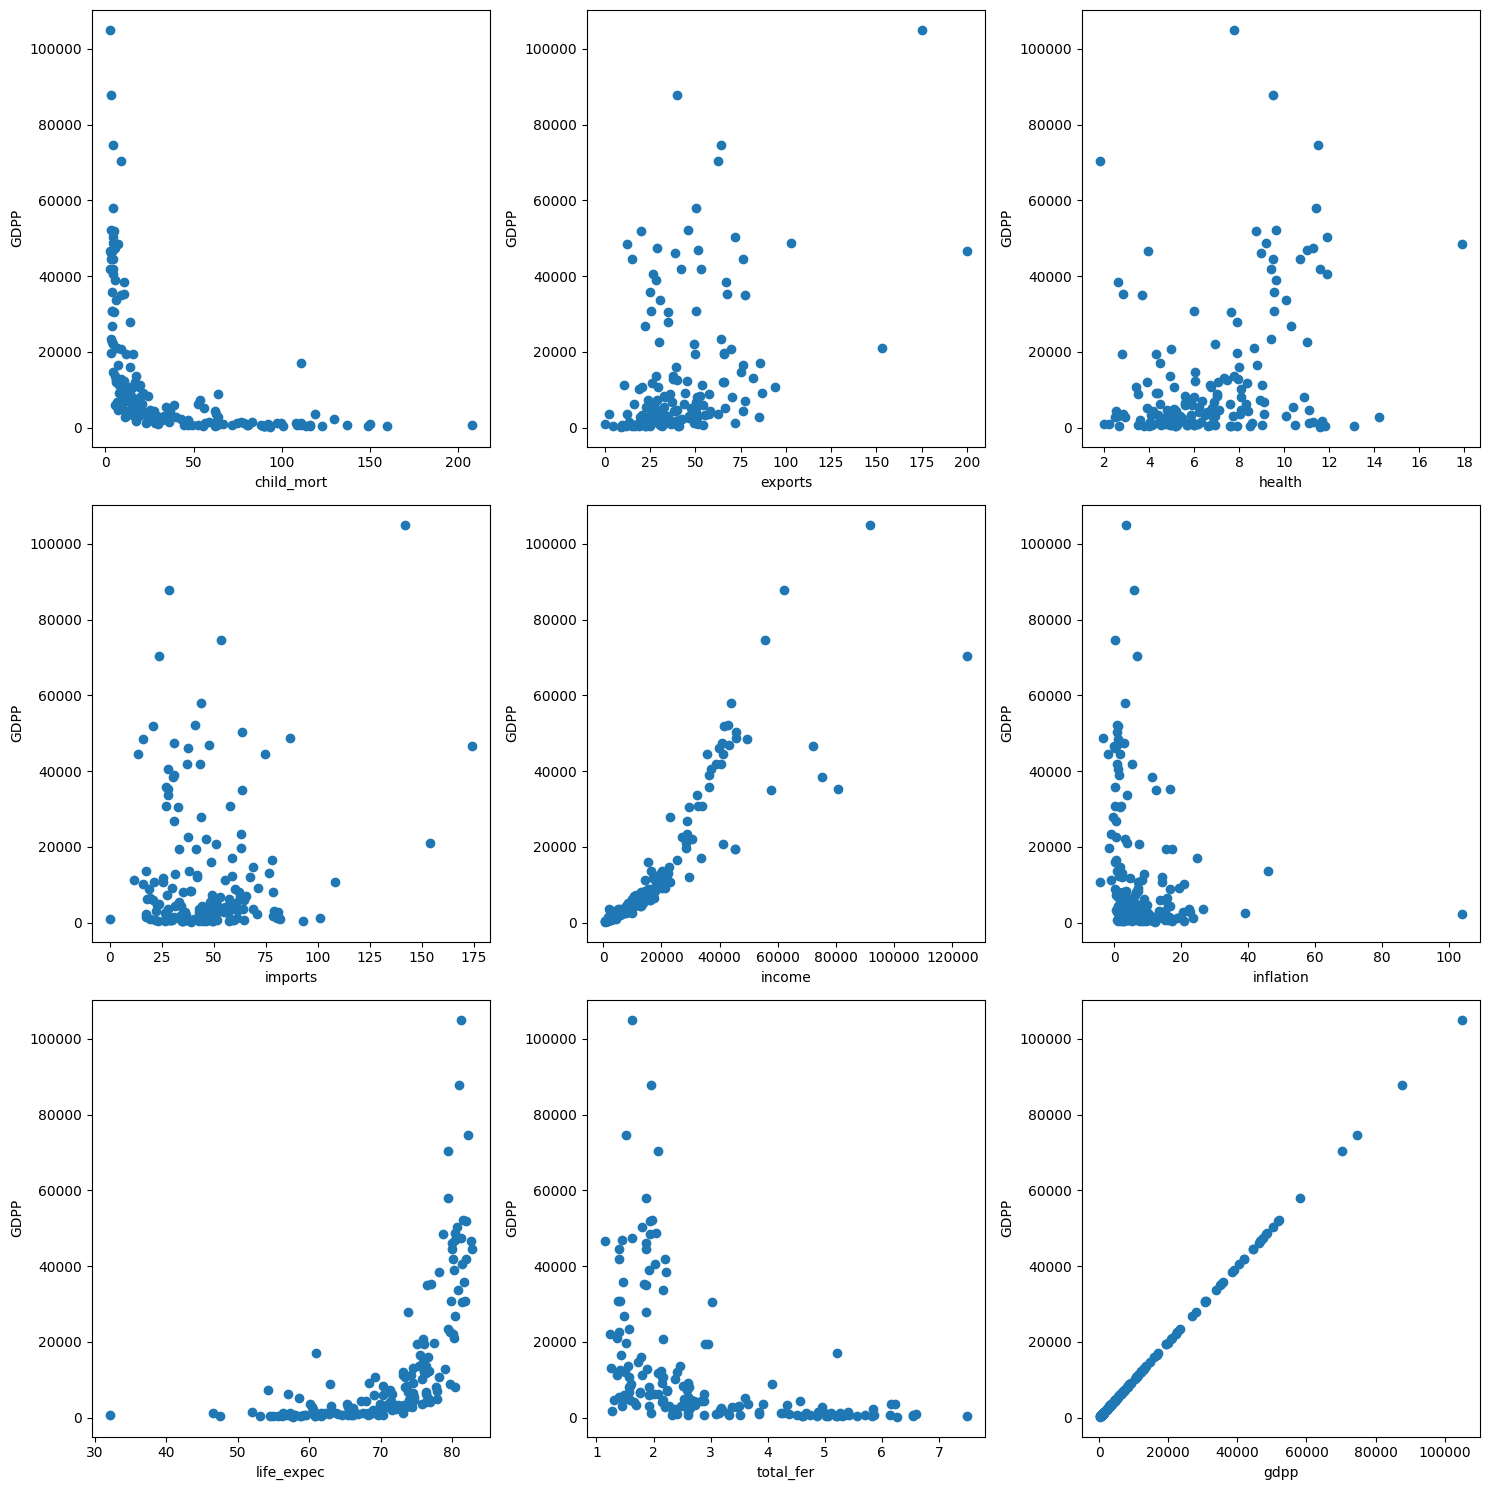

In [46]:
# Explore the continuous independent features against gdpp using scatter plots.
variables = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
gdpp = data['gdpp']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(data[var], gdpp)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('GDPP')

plt.tight_layout()
plt.show()


The scatter plots above indicate potential for identifying clusters based on the Gross Domestic Product per capita (GDPP) and various socio-economic indicators. 

* ### GDPP vs. Exports

Rationale: Higher exports typically correlate with a stronger economy and higher GDPP. This relationship can reveal clusters based on economic performance.

Clusters: Countries might cluster into groups with low GDPP and low exports, moderate GDPP and exports, and high GDPP with high exports.
* ### GDPP vs. Health Expenditure

Rationale: Countries that invest more in health tend to have higher GDPP due to better overall health and productivity of the population.

Clusters: Potential clusters include low GDPP and low health expenditure, moderate GDPP and health expenditure, and high GDPP with high health expenditure.
* ### GDPP vs. Imports

Rationale: Imports reflect a country's purchasing power and economic activity. Higher GDPP usually accompanies higher imports, reflecting strong domestic demand.

Clusters: Countries might cluster into groups with low GDPP and low imports, moderate GDPP and imports, and high GDPP with high imports.
* ### GDPP vs. Life Expectancy

Rationale: Life expectancy is a strong indicator of a country's healthcare system and overall living conditions, which generally improve with higher GDPP.

Clusters: We can expect clusters of countries with low GDPP and low life expectancy, moderate GDPP and life expectancy, and high GDPP with high life expectancy.
* ### GDPP vs. Total Fertility Rate

Rationale: Higher economic development often leads to lower fertility rates due to better access to education and family planning.

Clusters: Possible clusters include low GDPP with high fertility, moderate GDPP with moderate fertility, and high GDPP with low fertility.

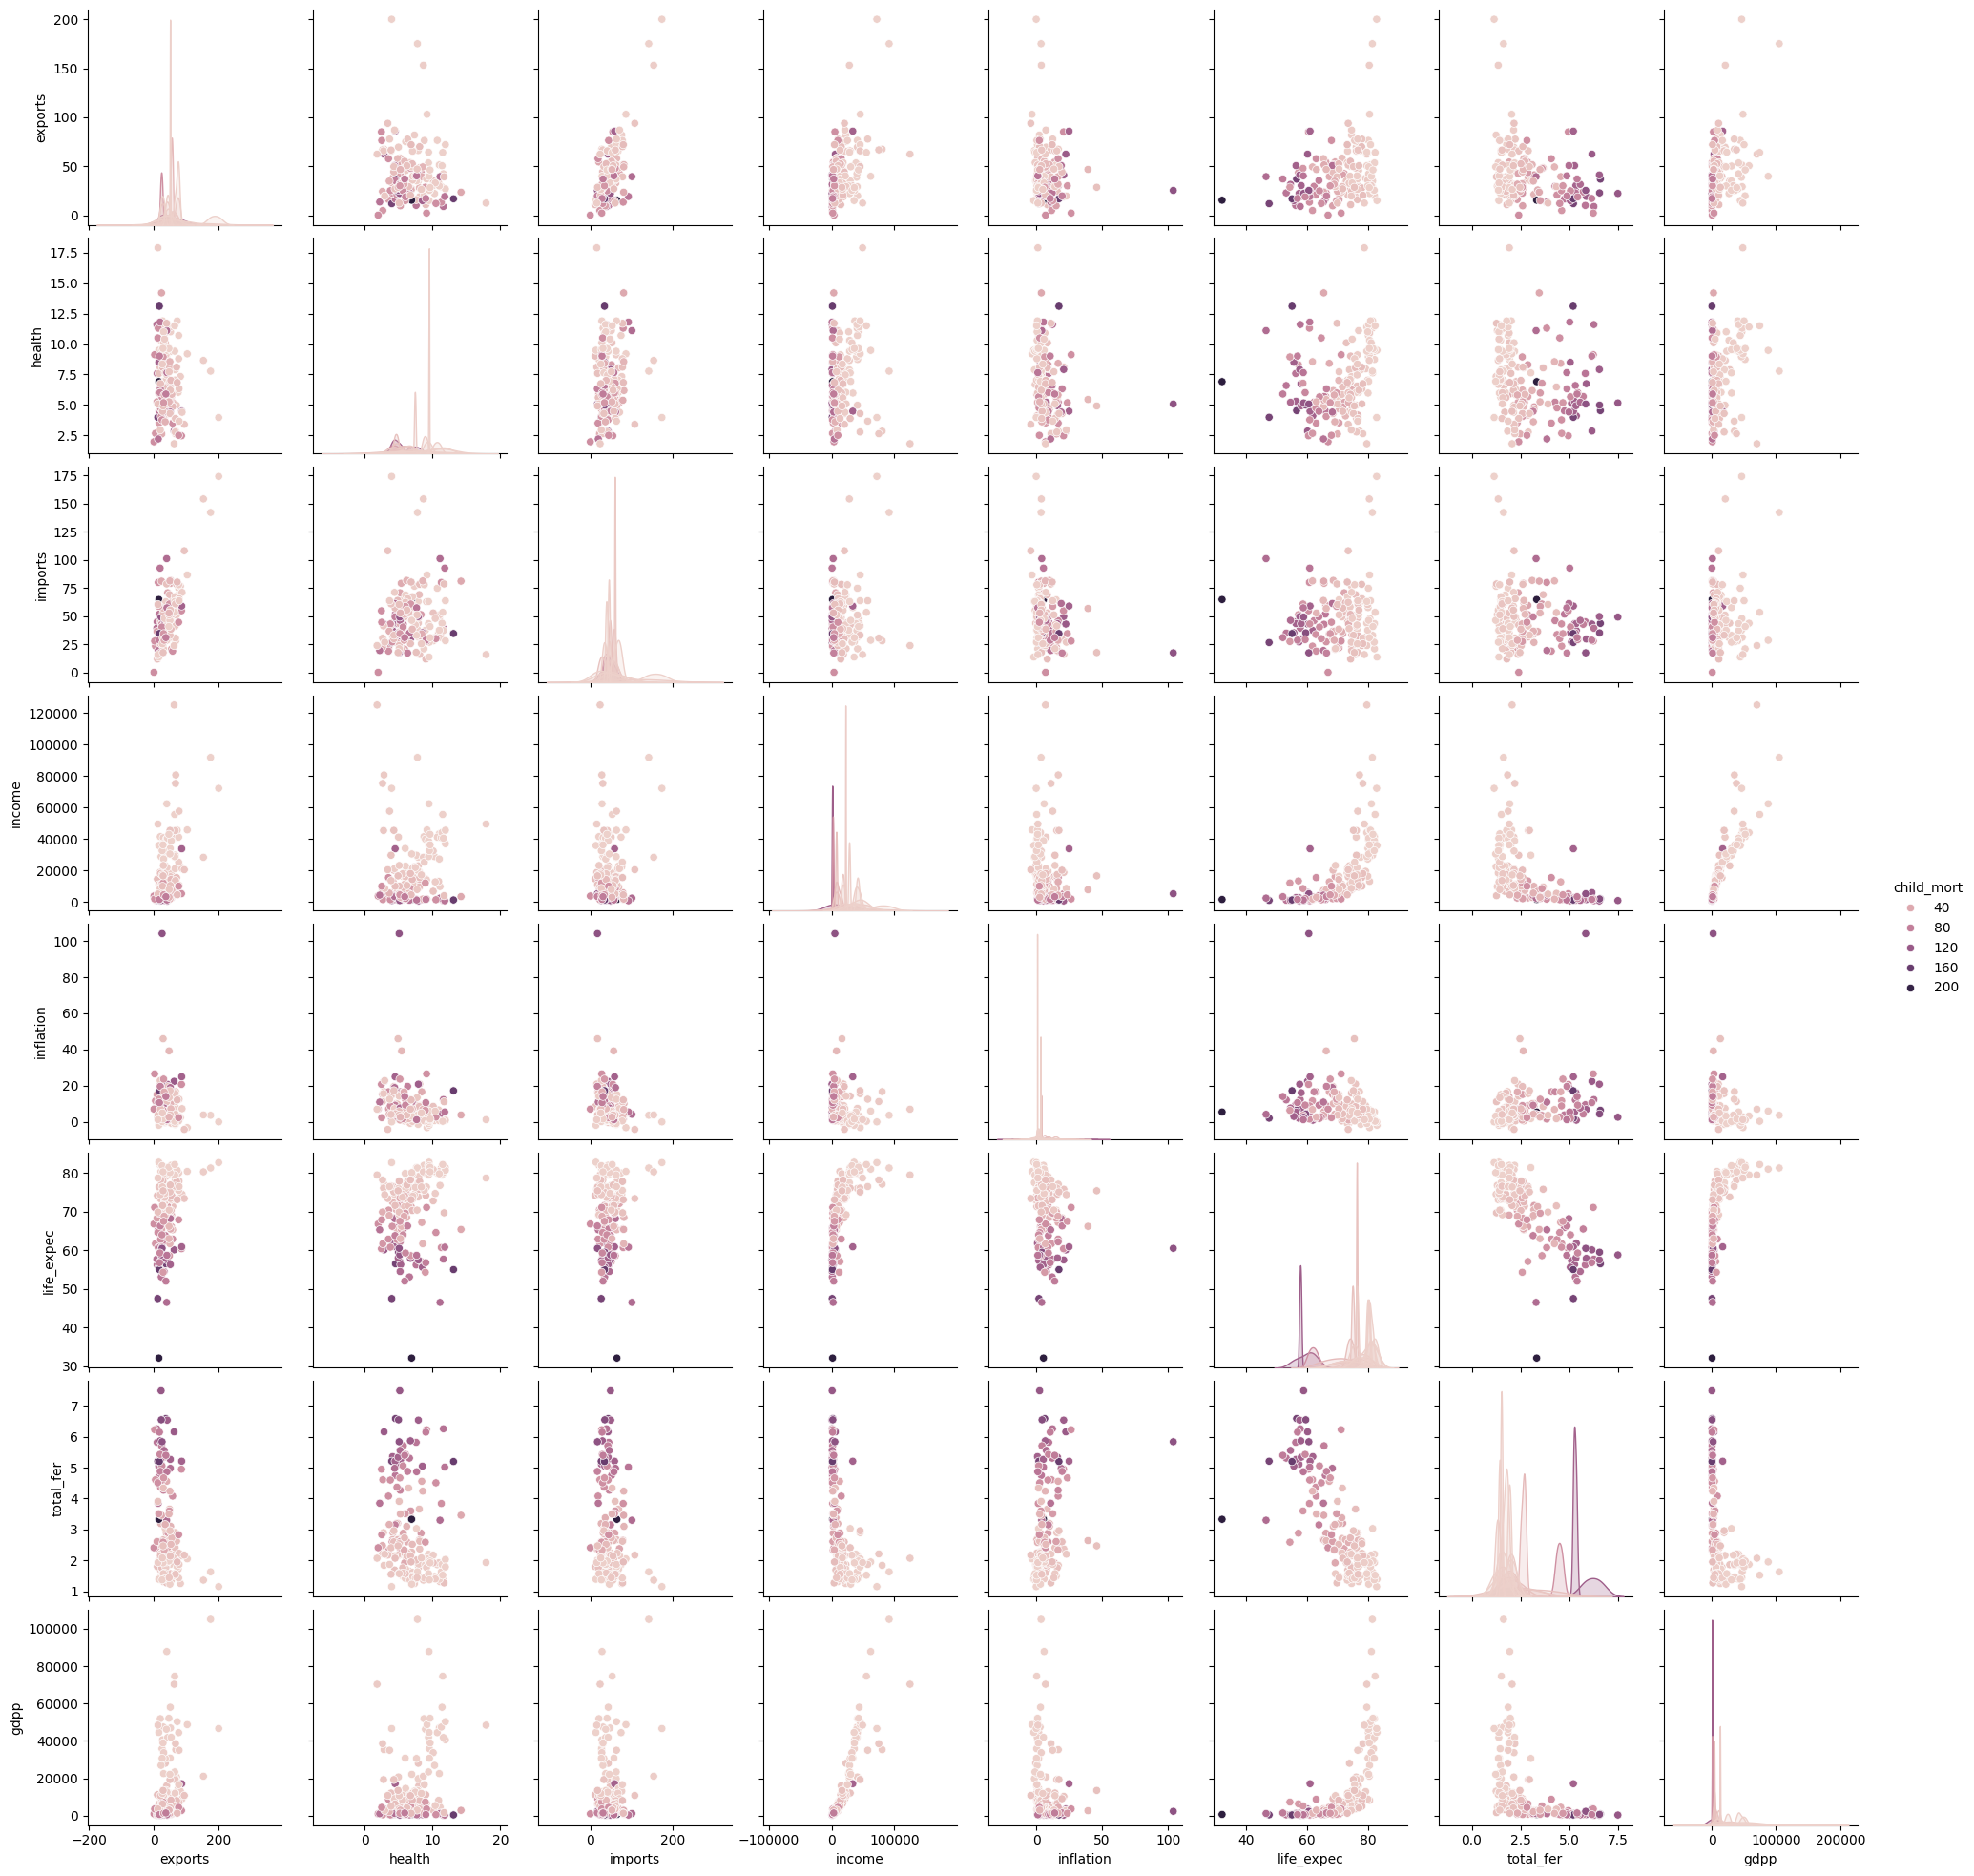

In [47]:
# Create a pair plot
sns.pairplot(data, hue="child_mort")

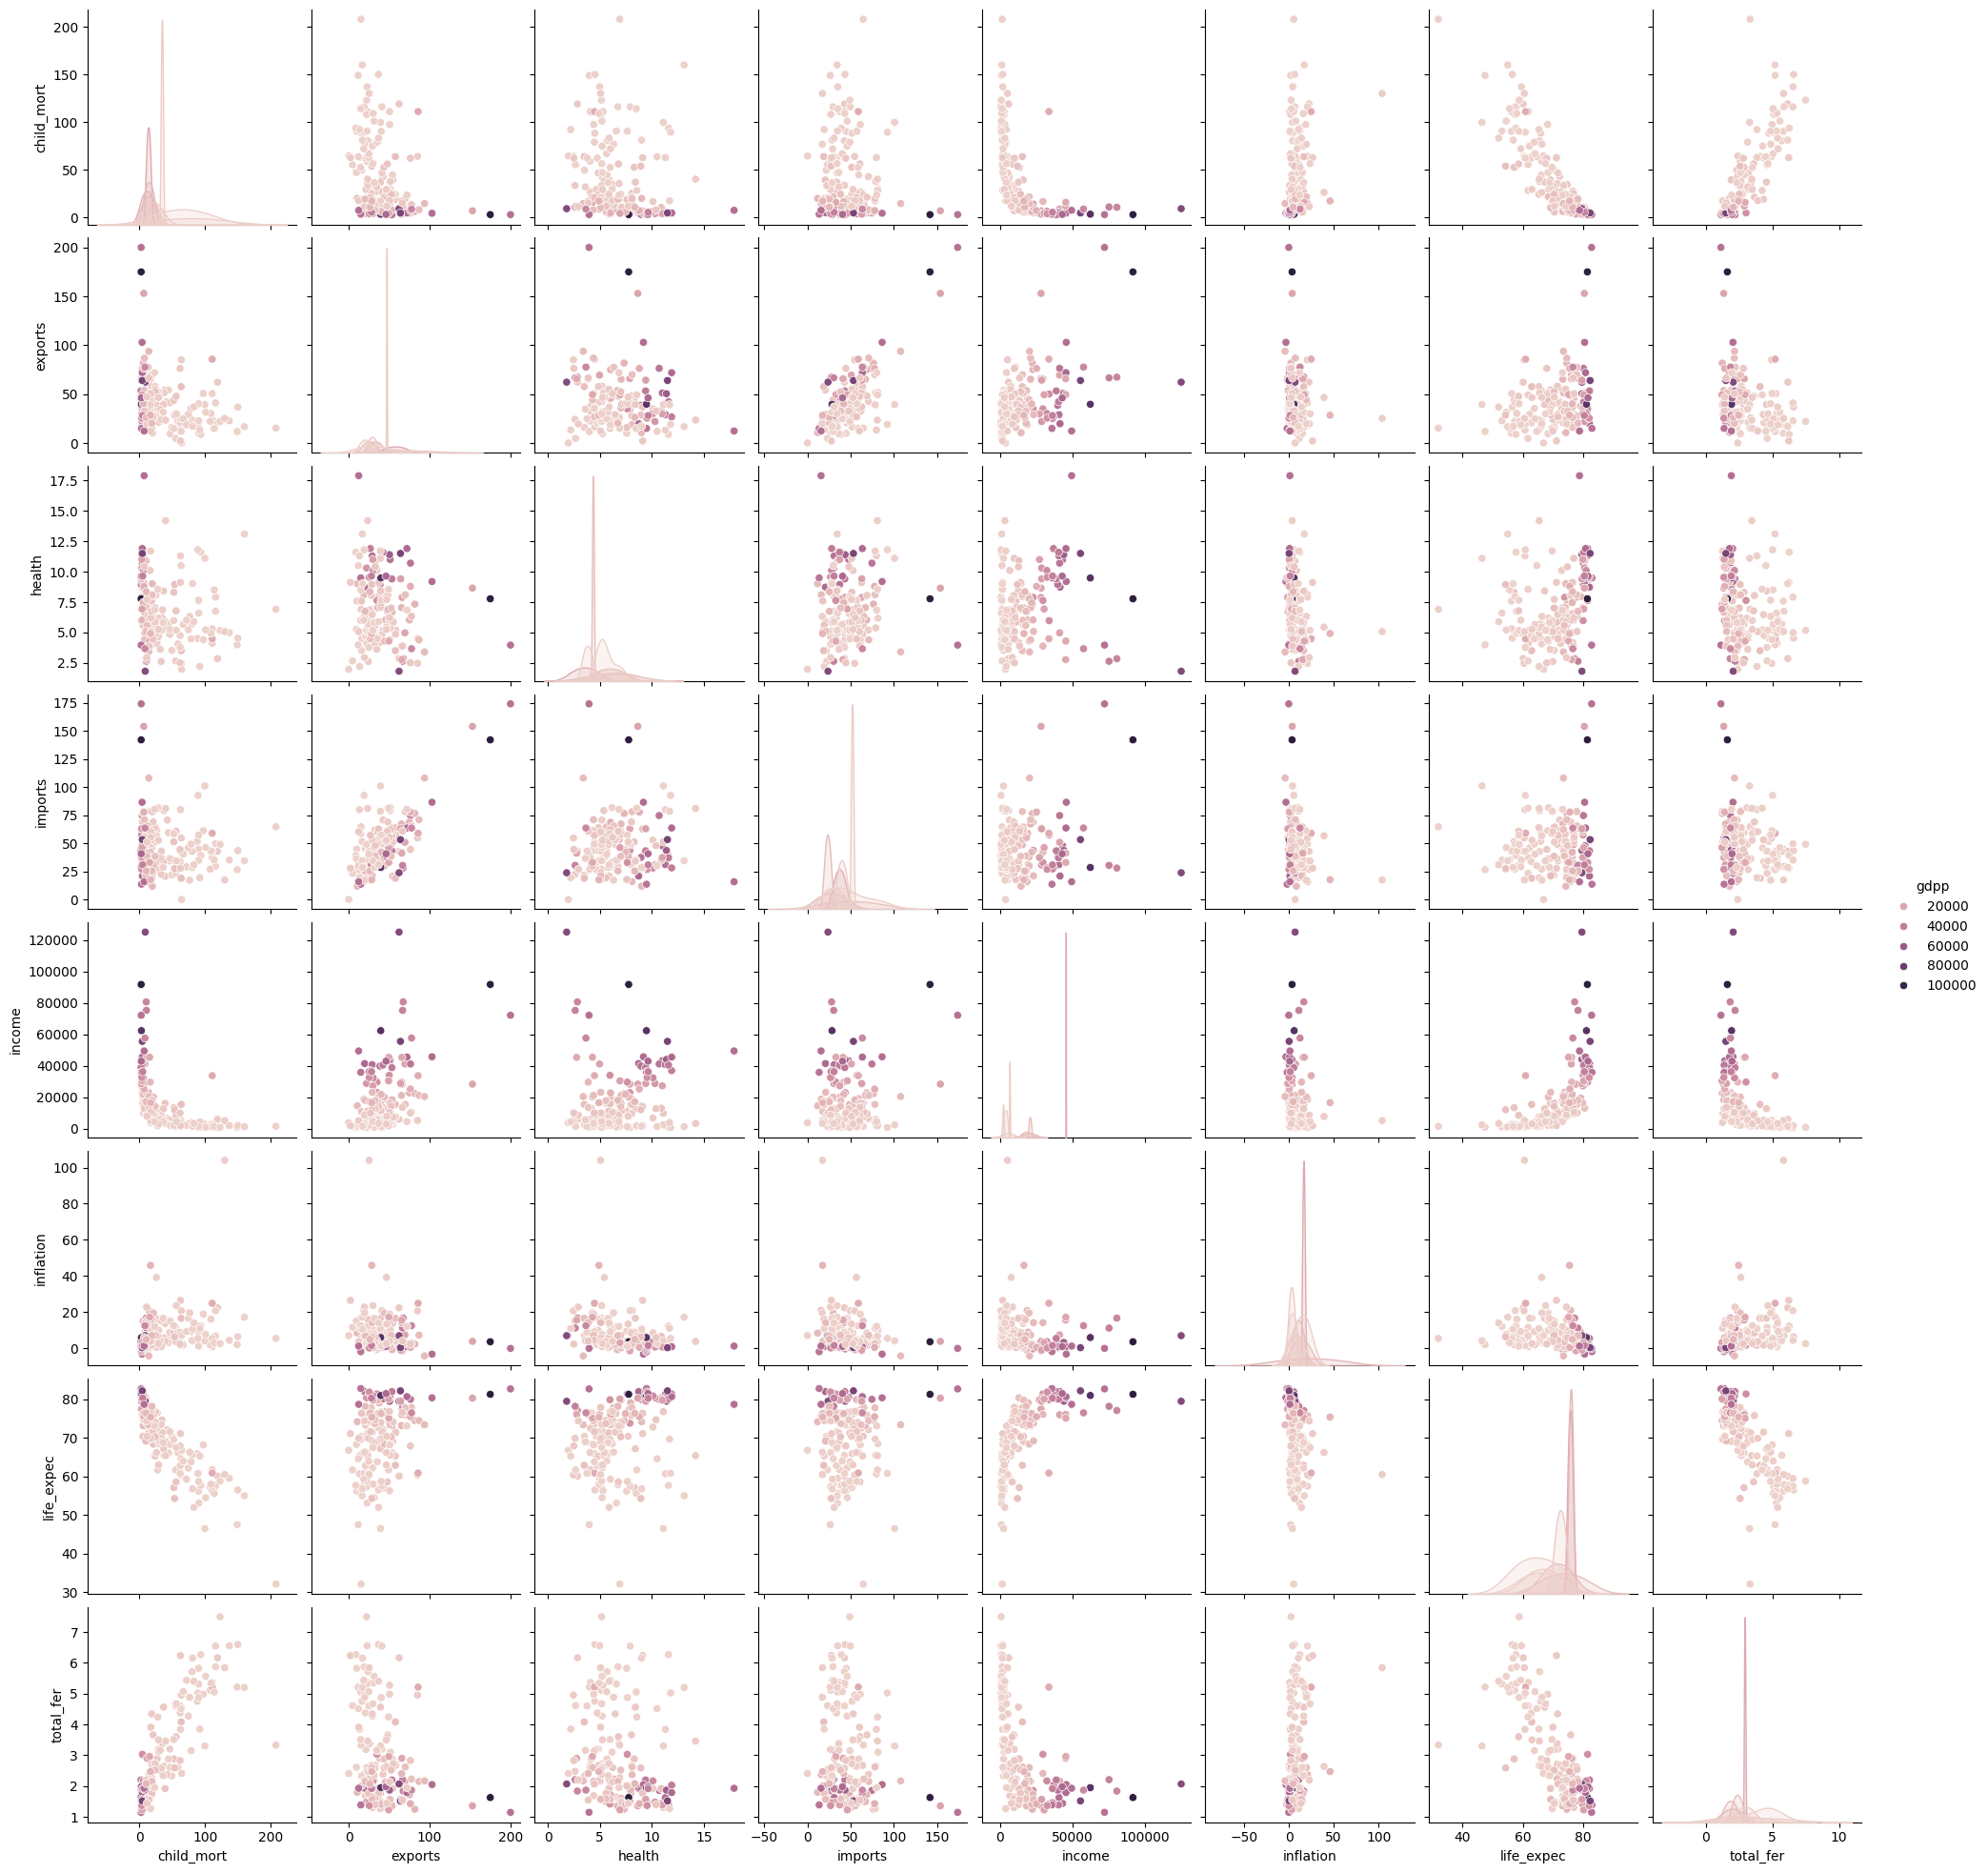

In [48]:
sns.pairplot(data, hue="gdpp")

Upon examining the pairplots generated from the dataset, it becomes evident that child mortality presents a compelling case for further exploration in the context of clustering analysis.

In the pairplots, child mortality stands out as a pivotal factor that intersects with various economic and socio-economic dimensions. Its ability to highlight distinct patterns and relationships makes it a valuable variable for clustering analysis. By focusing on child mortality in conjuction with other variables, we can gain deeper insights into the socio-economic conditions of different countries and identify meaningful clusters that reflect their development status, healthcare quality, and overall living standards.

### Scaling the Data

In [49]:
# Normalise the data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(data)

In [50]:
#  the first five lines of the data
print(df_scaled[:5])

[[0.42648491 0.04948197 0.35860783 0.25776487 0.00804721 0.12614361
  0.47534517 0.73659306 0.00307343]
 [0.06815969 0.13953104 0.29459291 0.27903729 0.07493307 0.08039922
  0.87179487 0.07886435 0.03683341]
 [0.12025316 0.1915594  0.14667495 0.18014926 0.0988094  0.1876906
  0.87573964 0.27444795 0.04036499]
 [0.56669912 0.31112456 0.06463642 0.24626626 0.04253523 0.24591073
  0.55226824 0.79022082 0.03148832]
 [0.03748783 0.22707876 0.2622747  0.33825512 0.14865223 0.05221329
  0.8816568  0.15457413 0.11424181]]


## K-Means Clustering

### Selecting K

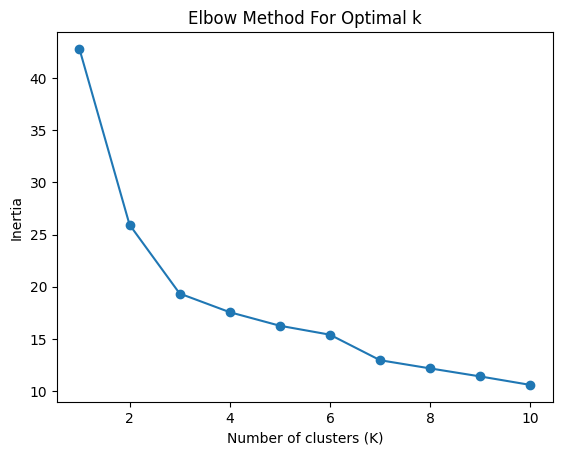

In [51]:
# Function to evaluate KMeans inertia
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

# Function to plot elbow curve
def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, max_k+1), within_cluster_vars, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled, max_k=10, r=42)



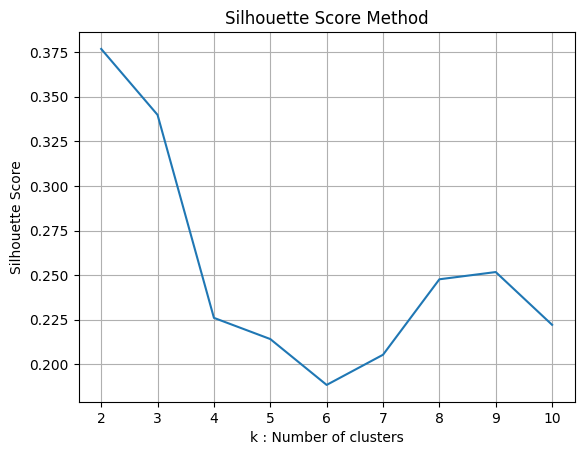

In [52]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the plots above, I believe that three is the optimal number of clusters. In the elbow plot, there is a noticeable "elbow" or sharp decline in WCSS (within-cluster sum of squares) that starts to plateau after three clusters. Additionally, the silhouette score shows a significant drop between three and four clusters, and beyond four clusters, the score stabilises and begins to plateau. 
This indicates that three clusters provide a good balance between minimizing within-cluster variance and maintaining well-defined, cohesive clusters.

## Fitting a K-Means Model with the selected K value

In [53]:
# Optimal number of clusters determined is 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled)

# Add cluster labels to the dataframe
data['cluster'] = kmeans.labels_

In [54]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.33976487765323604


## Predictions

## Visualisation of clusters

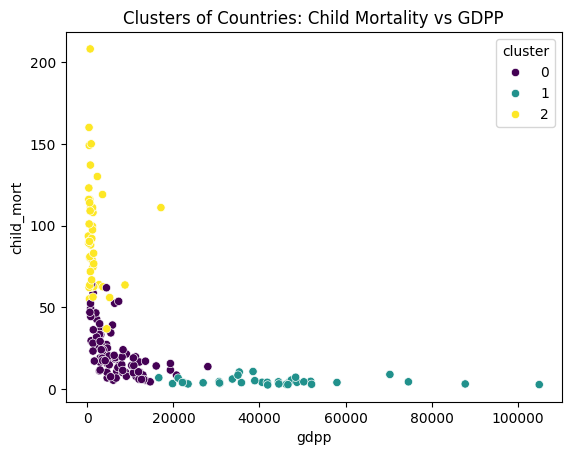

In [55]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(data=data, x='gdpp', y='child_mort', hue='cluster', palette='viridis')
plt.title('Clusters of Countries: Child Mortality vs GDPP')
plt.show()

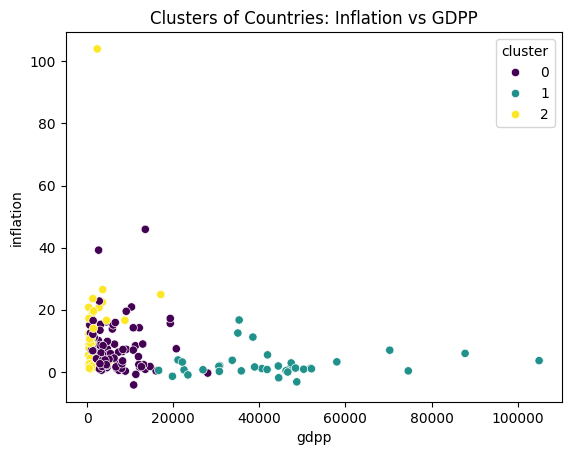

In [56]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(data=data, x='gdpp', y='inflation', hue='cluster', palette='viridis')
plt.title('Clusters of Countries: Inflation vs GDPP')
plt.show()

In [57]:
# Label the groups of countries in the plots
cluster_labels = {
    0: 'Developing',
    1: 'Developed',
    2: 'Least Developed'
}

data['cluster_label'] = data['cluster'].map(cluster_labels)

# Print the cluster label counts
print(data['cluster_label'].value_counts())

# Justify the labels assigned to each group
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} - {cluster_labels[cluster]}")
    cluster_data = data[data['cluster'] == cluster]
    print(cluster_data.describe())

cluster_label
Developing         87
Least Developed    45
Developed          35
Name: count, dtype: int64

Cluster 0 - Developing
       child_mort    exports     health     imports        income  inflation  \
count   87.000000  87.000000  87.000000   87.000000     87.000000  87.000000   
mean    22.490805  40.484931   6.242414   47.326045  12644.482759   7.599839   
std     14.388486  19.002087   2.165041   19.875540   8609.106693   7.713901   
min      4.500000   0.109000   1.970000    0.065900   1780.000000  -4.210000   
25%     11.600000  26.900000   4.885000   31.900000   6705.000000   2.485000   
50%     18.600000  37.600000   5.980000   48.700000  10500.000000   5.990000   
75%     29.150000  51.400000   7.525000   60.250000  16800.000000   9.905000   
max     64.400000  93.800000  14.200000  108.000000  45400.000000  45.900000   

       life_expec  total_fer          gdpp  cluster  
count   87.000000  87.000000     87.000000     87.0  
mean    72.457471   2.315632   6657.37931

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

Based on the provided statistics, the justification for labeling each cluster as "Developed," "Developing," and "Least Developed" is as follows:

* ### Cluster 0 - Developing

  * Child Mortality: The mean child mortality rate is 22.49, which is relatively low, indicating good healthcare but not as extensive as in the most developed nations. indicating better healthcare systems which are typically found in developed countries.
  * Income: The mean income is 12644.48, which is very high but considering the distribution and other factors, indicates high-income developing countries.
  * Life Expectancy: The mean life expectancy is 72.46 years, which is higher, reflecting good healthcare systems.
  * Health Expenditure: The average health expenditure is 6.24, which, while not the highest, indicates significant investment in healthcare.
  * Exports and Imports: The mean export and import values are 40.48 and 47.33 respectively, suggesting very robust economic activity and high levels of international trade, typical of rapidly developing economies.
  * Inflation: The average inflation rate is 7.60, which, although moderate, is manageable and consistent with more stable economic conditions.
  * GDP Per Capita: The mean GDP per capita is 6657.38, which, while variable, is higher and indicative of developing economies.
  * Total Fertility Rate: The mean total fertility rate is 2.32, which is lower, typical of developed countries, but other economic indicators place them in the high-income developing category.

These characteristics indicate that while the countries in this cluster have high income and robust economic activity, they are still categorized as developing due to certain socio-economic factors and growth dynamics.

* ### Cluster 1 - Developed

  * Child Mortality: The mean child mortality rate is 4.90, which is very low, indicating better healthcare systems which are typically found in developed countries.
  * Income: The mean income is 45802.86, which is significantly higher compared to the other clusters, indicative of developed economies.
  * Life Expectancy: The mean life expectancy is 80.25 years, which is higher, reflecting good healthcare systems.
  * Health Expenditure: The average health expenditure is 8.92, which is high, reflecting advanced healthcare, living standards and investment in healthcare.
  * Exports and Imports: The mean export and import values are 58.43 and 51.51 respectively, suggesting robust economic activity and high levels of international trade.
  * Inflation: The average inflation rate is 2.54, which is low and indicative of stable economic conditions.
  * GDP Per Capita: The mean GDP per capita is 43117.14, which is very high, suggesting significant economic output and living standards.
  * Total Fertility Rate: The mean total fertility rate is 1.74, which is low, typical of developed countries where birth rates tend to be lower due to different socio-economic factors.

These factors collectively suggest that the countries in this cluster are economically advanced with higher living standards, better healthcare, and stable economic conditions.

### Cluster 2 - Least Developed


* Child Mortality: The mean child mortality rate is 94.73, which is very high, indicating poor healthcare systems typical of least developed countries.
* Income: The mean income is 3555.40, which is low, characteristic of least developed economies.
* Life Expectancy: The mean life expectancy is 59.34 years, which is low, reflecting inadequate healthcare and living standards.
* Health Expenditure: The average health expenditure is 6.29, which is moderate but indicates limited healthcare resources.
* Exports and Imports: The mean export and import values are 28.84 and 42.46 respectively, suggesting limited economic activity.
* Inflation: The average inflation rate is 12.21, which is high and indicative of economic instability.
* GDP Per Capita: The mean GDP per capita is 1704.93, which is very low, reflecting poor economic output and living standards.
* Total Fertility Rate: The mean total fertility rate is 5.11, which is high, typical of least developed countries with higher birth rates.

These factors collectively indicate that the countries in this cluster are economically challenged with low income, poor healthcare, high child mortality, and economic instability.

In summary, the clusters are distinguished by key socio-economic indicators such as child mortality, income, life expectancy, health expenditure, and GDP per capita. Cluster 0 is labeled "Developing" due to high income but with characteristics of rapidly growing economies. Cluster 1 is labeled "Developing" due to higher income, better healthcare, and higher life expectancy. Cluster 2 is labeled "Least Developed" due to high child mortality, low income, and poor living standards.